# What is Image Segmentation?

Segmentation is usually the first step of image analysis. Image segmentation
meaningful regions where different features are retained in each of the images
can be described as separating. For example, similar brightness in the image
and these luminosities represent objects in different regions of the scene can.



# Image Segmentation What does it do?

These segments (segments-elements), which vary depending on the application,
as an example; air-ground photography, vehicles moving on the road and environment
a segmentation can be made to distinguish it from the road. (Around the road
a segmentation)

It should not be forgotten that a universalthere is no segmentation method and no segmentation
method is perfec.Another
in other words, image enhancement and repair problems such as the image
methods for segmenting, and performances of these methods,
depending on the image and application.

Automatic image segmentation is one of the most difficult operations of image processing.

# Segmentation (Segmentation) properties

Image Segmentation; R5: R1, R2 .... The division into Rn regions is shown.“Segmantasyon tamamlandığında:
• Each zone is uniform (Uniform).
• Regions do not overlap on one another.
• Pixels of a region have a common feature.
• Neighboring regions have different characteristics.
• Segmentation algorithms in gray level images, gray level (brightness)
values are based on the discontinuity and similarity feature.
•Discontinuity based segmentation algorithms; Isolated dot, thin line or picture
edges (varying in gray level values) discontinuities, low and high
based on the ability to detect using similar masks as in filtering.
•Similarity based segmentation algorithms; either thresholding, growing in area, or
division and consolidation.

# Similarity Based Image Segmentation Algorithms

According to similarities in gray level marks
Segmentation as region segmentation (region segmentation)
known.

Thresholding, growing, and splitting -
based on split-and-merge operations
Is performed.

The similarity of the gray levels of the pixels or
a view based on differences
The concept of segmentation is both static (static)
dynamic (time-varying) views
applicable.

#  Thresholding

Thresholding is most important for image segmentation purposes
one of the approaches. The purpose of the thresholding process is to create objects
image from the background

%matplotlib inline
import importlib
import glob
import os
import random
import numpy as np
from PIL import Image
import utils2; reload(utils2)
from utils2 import *
import threading
from matplotlib import pyplot as plt
#from keras.models import Model   
#from keras.layers import * 
#from keras.regularizers import l2

In [1]:
%matplotlib inline
import importlib
import utils2; reload(utils2)
from utils2 import *

Using TensorFlow backend.


In [2]:
path = 'camvid/'

In [3]:
images_path = path + '701_StillsRaw_full/'
labels_path = path + 'LabeledApproved_full/'

In [4]:
images = glob.glob(images_path + '*.png')
print (images[:3])

labels = [labels_path + os.path.basename(i)[:-4] + '_L.png' for i in images]
print (labels[:3])

['camvid/701_StillsRaw_full/0016E5_00901.png', 'camvid/701_StillsRaw_full/0016E5_06660.png', 'camvid/701_StillsRaw_full/Seq05VD_f04440.png']
['camvid/LabeledApproved_full/0016E5_00901_L.png', 'camvid/LabeledApproved_full/0016E5_06660_L.png', 'camvid/LabeledApproved_full/Seq05VD_f04440_L.png']


In [5]:
image_size = (480,360)

In [6]:
def open_image(img):
    return np.array(Image.open(img).resize(image_size, Image.NEAREST))

In [7]:
imgs = np.stack([open_image(i) for i in images])
imgs.shape

(701, 360, 480, 3)

In [8]:
lbs = np.stack([open_image(l) for l in labels])
lbs.shape

(701, 360, 480, 3)

In [9]:
imgs = imgs/255.

In [10]:
mean = imgs.mean() 

In [11]:
std = imgs.std()

In [12]:
mean, std

(0.39996644266361203, 0.30179491142291076)

In [13]:
imgs-=imgs.mean()
imgs/=imgs.std()

In [14]:
# save_array('imgs.bc', imgs)
# save_array('lbs.bc', labels)

In [15]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [16]:
bi = BatchIndices(10,3, True)
#[next(bi) for o in range(5)]
[bi.__next__() for o in range(5)]

[array([9, 6, 7]),
 array([5, 1, 2]),
 array([8, 3, 0]),
 array([4]),
 array([6, 3, 8])]

In [17]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        #idxs = next(self.idx_gen)
        idxs = self.idx_gen.__next__()
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

In [18]:
sg = segm_generator(imgs, lbs, 4, train=False)
#b_img, b_label = next(sg)
b_img, b_label = sg.__next__()

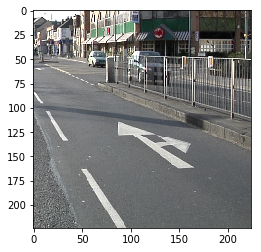

In [19]:
plt.imshow(b_img[0]*0.3+0.4);

In [20]:
def parse_code(l):
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [21]:
label_codes, label_names = zip(*[parse_code(l) for l in open(path+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

len(label_names)

32

In [22]:
label_codes, label_names

([(64, 128, 64),
  (192, 0, 128),
  (0, 128, 192),
  (0, 128, 64),
  (128, 0, 0),
  (64, 0, 128),
  (64, 0, 192),
  (192, 128, 64),
  (192, 192, 128),
  (64, 64, 128),
  (128, 0, 192),
  (192, 0, 64),
  (128, 128, 64),
  (192, 0, 192),
  (128, 64, 64),
  (64, 192, 128),
  (64, 64, 0),
  (128, 64, 128),
  (128, 128, 192),
  (0, 0, 192),
  (192, 128, 128),
  (128, 128, 128),
  (64, 128, 192),
  (0, 0, 64),
  (0, 64, 64),
  (192, 64, 128),
  (128, 128, 0),
  (192, 128, 192),
  (64, 0, 64),
  (192, 192, 0),
  (0, 0, 0),
  (64, 192, 0)],
 ['Animal',
  'Archway',
  'Bicyclist',
  'Bridge',
  'Building',
  'Car',
  'CartLuggagePram',
  'Child',
  'Column_Pole',
  'Fence',
  'LaneMkgsDriv',
  'LaneMkgsNonDriv',
  'Misc_Text',
  'MotorcycleScooter',
  'OtherMoving',
  'ParkingBlock',
  'Pedestrian',
  'Road',
  'RoadShoulder',
  'Sidewalk',
  'SignSymbol',
  'Sky',
  'SUVPickupTruck',
  'TrafficCone',
  'TrafficLight',
  'Train',
  'Tree',
  'Truck_Bus',
  'Tunnel',
  'VegetationMisc',
  'Void'

In [23]:
code2id = {v:k for k,v in enumerate(label_codes)}

id2code = {k:v for k,v in enumerate(label_codes)}

In [24]:
code2id

{(0, 0, 0): 30,
 (0, 0, 64): 23,
 (0, 0, 192): 19,
 (0, 64, 64): 24,
 (0, 128, 64): 3,
 (0, 128, 192): 2,
 (64, 0, 64): 28,
 (64, 0, 128): 5,
 (64, 0, 192): 6,
 (64, 64, 0): 16,
 (64, 64, 128): 9,
 (64, 128, 64): 0,
 (64, 128, 192): 22,
 (64, 192, 0): 31,
 (64, 192, 128): 15,
 (128, 0, 0): 4,
 (128, 0, 192): 10,
 (128, 64, 64): 14,
 (128, 64, 128): 17,
 (128, 128, 0): 26,
 (128, 128, 64): 12,
 (128, 128, 128): 21,
 (128, 128, 192): 18,
 (192, 0, 64): 11,
 (192, 0, 128): 1,
 (192, 0, 192): 13,
 (192, 64, 128): 25,
 (192, 128, 64): 7,
 (192, 128, 128): 20,
 (192, 128, 192): 27,
 (192, 192, 0): 29,
 (192, 192, 128): 8}

In [25]:
failed_code = len(label_codes)+1
failed_code

33

In [26]:
n,r,c,ch = imgs.shape
n, r, c, ch

(701, 360, 480, 3)

In [27]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(lbs[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [28]:
from concurrent.futures import ProcessPoolExecutor

In [29]:
def conv_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))

In [30]:
labels_int = conv_all_labels()

In [31]:
# save_array('labels_int.bc', labels_int)

In [32]:
np.count_nonzero(labels_int==failed_code)

44

In [33]:
l = []
for i in range(len(labels_int)):
    if np.count_nonzero(labels_int[i]==failed_code) > 0:
        l.append(i)

print (len(l))

1


In [34]:
l

[130]

In [35]:
labels_int = np.delete(labels_int, l, axis=0)
len(labels_int)

700

In [36]:
labels_int.shape

(700, 360, 480)

In [37]:
np.count_nonzero(labels_int==failed_code)

0

In [38]:
imgs = np.delete(imgs, l, axis=0)
len(imgs)

700

In [39]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            var = id2code[a[j,k]]
            res[j,k] = var
    return res

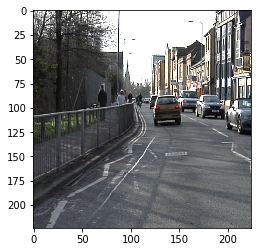

In [40]:
sg = segm_generator(imgs, lbs, 4, train=True)
#b_img, b_label = next(sg)
b_img, b_label = sg.__next__()
plt.imshow(b_img[0]*0.3+0.4)

In [41]:
def dict_color_label(x):
    l = [code2id[tuple(i)] for i in x]
    l = np.array(l)
    return l

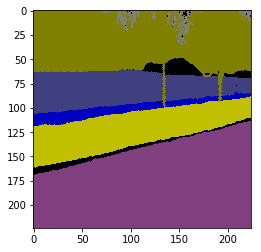

In [42]:
temp = dict_color_label(b_label[0])
plt.imshow(color_label(np.resize(temp, (224,224))))

## Creating Test Set

In [43]:
train_set = imgs[:468]
train_labels = labels_int[:468]

test_set = imgs[468:]
test_labels = labels_int[468:]

In [44]:
len(train_set), len(test_set), len(train_labels), len(test_labels)

(468, 232, 468, 232)

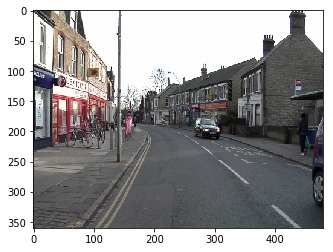

In [45]:
plt.imshow(train_set[462]*0.3+0.4)

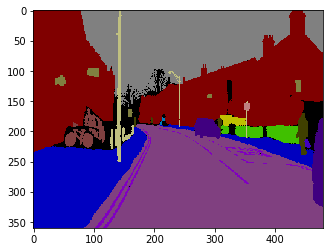

In [46]:
plt.imshow(color_label(train_labels[462]))

In [47]:
train_labels[0].shape

(360, 480)

In [48]:
train_generator = segm_generator(train_set, train_labels, 3, train=True)
test_generator = segm_generator(test_set, test_labels, 3, train=False)

In [49]:
#i,la = next(train_generator)
i,la = train_generator.__next__()

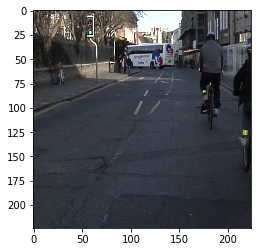

In [50]:
plt.imshow(i[0]*0.3+0.4)

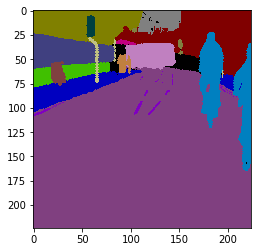

In [51]:
# t = dict_color_label(la[0])
plt.imshow(color_label(np.resize(la[0], (224,224))))

In [52]:
la[0].shape

(50176, 1)

In [53]:
from keras.layers import merge

In [54]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=2, axis=-1)(x)
#def bn(x): return BatchNormalization(axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return merge(xs, mode='concat', concat_axis=-1)

In [55]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

In [56]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

In [57]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

In [58]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

In [59]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

In [60]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

In [61]:
def reverse(a): return list(reversed(a))

In [62]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

In [63]:
input_shape = (224,224,3)
#img_input = Input(shape=input_shape)
img_input = Input(shape=input_shape)
x = create_tiramisu(32, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [64]:
model = Model(img_input, x)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


I have trained this model only for 2 epochs since I didn't have any more GPU computation time left. But you can train it for 500 epochs or so to get state of the art results. Do some finetuning(learning rate annealing also.)

In [65]:
model.fit_generator(train_generator, len(train_set), 2, verbose=2,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/2


ResourceExhaustedError: OOM when allocating tensor with shape[3,16,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv2D_96 = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Relu_95, convolution2d_97_W/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Mean_3/_1579 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_37826_Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op u'Conv2D_96', defined at:
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/tornado/ioloop.py", line 1008, in start
    self._run_callback(self._callbacks.popleft())
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-63-29aec8b0404c>", line 4, in <module>
    x = create_tiramisu(32, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)
  File "<ipython-input-62-caccb4a5778b>", line 10, in create_tiramisu
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
  File "<ipython-input-60-4681fff9ac85>", line 5, in up_path
    x,added = dense_block(n,x,growth_rate,p,wd)
  File "<ipython-input-56-c5128c867628>", line 4, in dense_block
    b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
  File "<ipython-input-55-556c7802024f>", line 7, in conv_relu_bn
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)
  File "<ipython-input-55-556c7802024f>", line 3, in conv
    subsample=(stride,stride), W_regularizer=l2(wd))(x)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/keras/engine/topology.py", line 572, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/keras/engine/topology.py", line 635, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/keras/engine/topology.py", line 166, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/keras/layers/convolutional.py", line 475, in call
    filter_shape=self.W_shape)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 2691, in conv2d
    x = tf.nn.conv2d(x, kernel, strides, padding=padding)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 639, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/mucahit/anaconda2/envs/keras1_2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,16,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv2D_96 = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Relu_95, convolution2d_97_W/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Mean_3/_1579 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_37826_Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
model.save_weights('tiramisu_2_iterations.h5')

In [ ]:
predictions = model.predict_generator(test_generator, len(test_set))

In [ ]:
predictions = np.argmax(predictions, axis=-1)

In [ ]:
predictions[0].shape

In [ ]:
plt.imshow(color_label(np.resize(predictions[6], (224,224))))

In [ ]:
plt.imshow(test_labels[3])

In [ ]:
j, t_la = next(test_generator)

In [ ]:
plt.imshow(j[0]*0.3+0.4)

In [ ]:
try_image = np.array(Image.open('Seq05VD_f05100.png').resize((224,224), Image.NEAREST))
try_image = try_image/255.
try_image-=mean
try_image/=std
try_image.shape

In [ ]:
try_preds = model.predict(np.expand_dims(try_image, 0), 1)

In [ ]:
try_preds = np.argmax(try_preds, axis=-1)
try_preds.shape

In [ ]:
plt.imshow(color_label(np.resize(try_preds[0], (224,224))))

In [ ]:
try_img = np.array(Image.open('Seq05VD_f05100.png').resize(image_size, Image.NEAREST))
try_img = try_img/255.
try_img-=mean
try_img/=std

In [ ]:
try_label = np.array(Image.open('Seq05VD_f05100_L.png').resize(image_size, Image.NEAREST))

In [ ]:
try_gen = segm_generator(np.expand_dims(try_img, 0), np.expand_dims(try_img, 0), 1, train=False)

In [ ]:
prd = model.predict_generator(try_gen, 1)

In [ ]:
prd = np.argmax(prd, axis=-1)

In [ ]:
prd.shape

In [ ]:
plt.imshow(color_label(np.resize(prd[0], (224,224))))